As last time, we will load in some libraries for doing the modelling of the images.



In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import torch
import scipy
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import torch
from transformers import AutoProcessor, AutoImageProcessor, ViTModel, SiglipModel

from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, ConfusionMatrixDisplay

ubase = "https://raw.githubusercontent.com/distant-viewing/hdpy/refs/heads/main/"
theme_set(theme_minimal())

import warnings
warnings.filterwarnings('ignore')
theme_set(theme_minimal())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



We will also create two objects right now that will allow us to apply the concepts
from the notes to our image dataset.



In [2]:
class ViTEmbedder:
    def __init__(self, model_name="google/vit-base-patch16-224", pooling="mean"):
        self.pooling = pooling.lower()
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
        self.model = ViTModel.from_pretrained(model_name, add_pooling_layer=False).eval().to(self.device)

    @torch.inference_mode()
    def __call__(self, image_path):
        inputs = {k: v.to(self.device) for k, v in self.processor(images=Image.open(image_path).convert("RGB"), return_tensors="pt").items()}
        hidden = self.model(**inputs).last_hidden_state
        vec = torch.nn.functional.normalize(hidden[:, 0, :] if self.pooling == "cls" else hidden[:, 1:, :].mean(dim=1), p=2, dim=-1)
        return vec.squeeze(0).cpu().numpy()

class SigLIPEmbedder:
    def __init__(self, model_name="google/siglip-base-patch16-256", device=None):
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = AutoProcessor.from_pretrained(model_name, use_fast=True)
        self.model = SiglipModel.from_pretrained(model_name).eval().to(self.device)

    @torch.inference_mode()
    def embed_image(self, image_path):
        inputs = self.processor(images=Image.open(image_path).convert("RGB"), return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        vec = torch.nn.functional.normalize(self.model.get_image_features(**inputs), p=2, dim=-1)
        return vec.squeeze(0).cpu().numpy()

    @torch.inference_mode()
    def embed_text(self, text):
        inputs = self.processor(text=text, return_tensors="pt", padding="max_length")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        vec = torch.nn.functional.normalize(self.model.get_text_features(**inputs), p=2, dim=-1)
        return vec.squeeze(0).cpu().numpy()

    def score(self, v1, v2):
        similarity = np.dot(v1, v2)
        temperature = self.model.logit_scale.item()
        bias = self.model.logit_bias.item()
        logit = bias + similarity * np.exp(temperature)
        return scipy.special.expit(logit)

def show_images(paths, labels):
    paths = paths.values; labels = labels.values
    n = min(12, len(paths), len(labels))
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    for ax in axes: ax.axis('off')
    for i in range(n):
        axes[i].imshow(Image.open("images/" + paths[i]))
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()



Finally, we also need to grab the image dataset again:



In [3]:
! wget -nc humanitiesdata.org/images.zip
! unzip images.zip -d .

--2025-11-12 15:33:55--  http://humanitiesdata.org/images.zip
Resolving humanitiesdata.org (humanitiesdata.org)... 51.222.48.183
Connecting to humanitiesdata.org (humanitiesdata.org)|51.222.48.183|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://humanitiesdata.org/images.zip [following]
--2025-11-12 15:33:55--  https://humanitiesdata.org/images.zip
Connecting to humanitiesdata.org (humanitiesdata.org)|51.222.48.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115032227 (110M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 109.70M  12.1MB/s    in 11s     

2025-11-12 15:34:07 (10.1 MB/s) - ‘images.zip’ saved [115032227/115032227]

Archive:  images.zip
   creating: ./images/
   creating: ./images/hand/
  inflating: ./images/hand/image-00736.jpg  
  inflating: ./images/hand/image-00520.jpg  
  inflating: ./images/hand/image-00468.jpg  
  inflating: ./images/hand/image-00681.jpg  
 



And now, let's get started!

## 1. Deep Learning Embedding

We will load the same metadata as last time:



In [4]:
df = pd.read_csv(ubase + "data/image_catalog.csv")
df

,label,path,label2
0,classroom,classroom/image-00032.jpg,classroom
1,classroom,classroom/image-00033.jpg,classroom
2,classroom,classroom/image-00034.jpg,classroom
3,classroom,classroom/image-00035.jpg,classroom
4,classroom,classroom/image-00036.jpg,classroom
...,...,...,...
1214,plant,plant/image-01187.jpg,plant
1215,plant,plant/image-01188.jpg,plant
1216,plant,plant/image-01189.jpg,plant
1217,plant,plant/image-01190.jpg,plant




And then load the Embedding model that has pre-trained features that we can
use for our model.



In [5]:
vit = ViTEmbedder()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]



And then, we will apply the embedding to each of the images. This might
take a few minutes to finish. Be patient!



In [6]:
X = []
for p in sorted(df['path']):
    X.append(vit("images/" + p))



From this point, everything is very similar to what we did last time. We create
the training and testing split:



In [7]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



And then run the logistic regression model. Here, I've added a few options to
make the model more performant with embeddings.



In [8]:
model = LogisticRegressionCV(
    penalty='l2',
    max_iter=10000,
    solver='liblinear',
    multi_class='ovr'
)
_ = model.fit(X_train, y_train)



And here is the error rate. You should see that it is a lot smaller than
the models we built previously.



In [9]:
y_pred_lreg = model.predict(X_test)
1 - accuracy_score(y_test, y_pred_lreg)

0.05245901639344264



And we see that the confusion matrix shows that only a few of the images
are mis-classified.



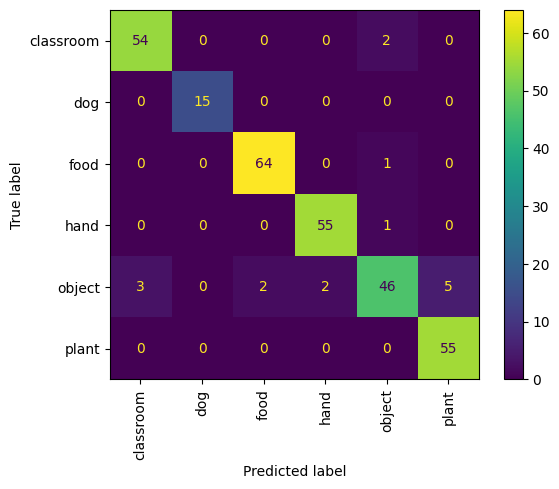

In [10]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lreg,
    display_labels=model.classes_,
    xticks_rotation="vertical"
)



As before, we can explore the data by computing all of the probabilities from
the model:



In [11]:
pred = pd.DataFrame(model.predict_proba(X))
pred.columns = model.classes_
pred['path'] = df['path']
pred['label'] = df['label']
pred['pred'] = model.predict(X)
pred

,classroom,dog,food,hand,object,plant,path,label,pred
0,0.998363,0.000152,0.000119,0.000964,0.000372,0.000029,classroom/image-00032.jpg,classroom,classroom
1,0.997023,0.000228,0.000164,0.000364,0.002202,0.000020,classroom/image-00033.jpg,classroom,classroom
2,0.998448,0.000181,0.001022,0.000174,0.000161,0.000015,classroom/image-00034.jpg,classroom,classroom
3,0.999156,0.000067,0.000492,0.000237,0.000011,0.000038,classroom/image-00035.jpg,classroom,classroom
4,0.994517,0.000132,0.000746,0.001485,0.003085,0.000034,classroom/image-00036.jpg,classroom,classroom
...,...,...,...,...,...,...,...,...,...
1214,0.003571,0.000102,0.000724,0.000193,0.000031,0.995378,plant/image-01187.jpg,plant,plant
1215,0.000627,0.000249,0.000629,0.000486,0.000877,0.997132,plant/image-01188.jpg,plant,plant
1216,0.001687,0.000245,0.000499,0.000751,0.003584,0.993233,plant/image-01189.jpg,plant,plant
1217,0.005183,0.000081,0.000116,0.002005,0.005246,0.987370,plant/image-01190.jpg,plant,plant




And then looking at the mis-classified images.



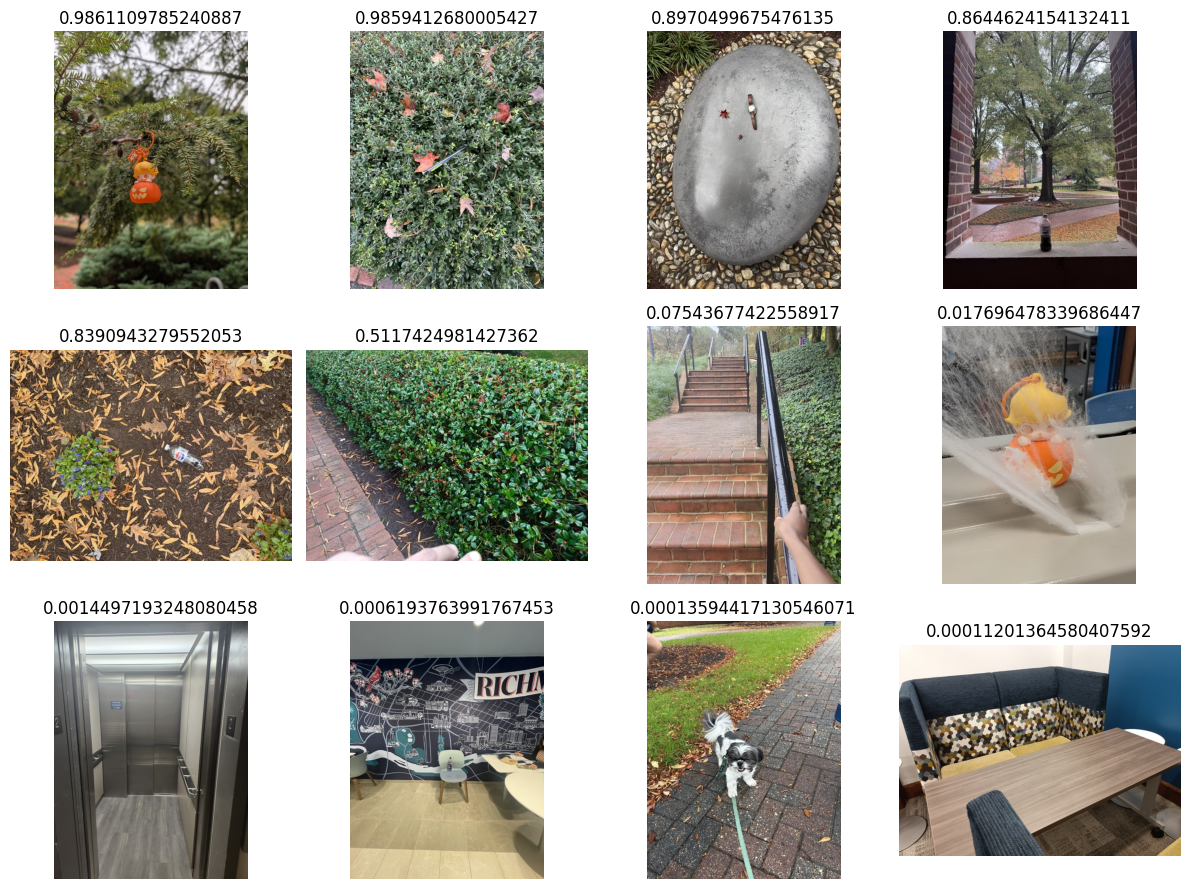

In [15]:
temp = pred.query("label != pred").sort_values("plant", ascending=False)
show_images(temp["path"], temp["plant"])



Make sure to do this with a few different categories.

## 2. Zero-shot

As we saw in the notes, we can also prooduce a zero-shot model to categorize
the images without any labeled data. Let's read in the SigLIP Embedder, which
can do both text and image embeddings:



In [17]:
siglip = SigLIPEmbedder()



We will cycle through all of the images and compute the model embeddings. This
again may take a few minutes, so be patient.



In [18]:
Z = []
for p in df['path'].values:
    Z.append(siglip.embed_image("images/" + p))

Z = np.vstack(Z)



STOP! Are you just quickly running all of the code without reading it? This is
a good place to stop because the chunk below has a lot of fun possible things
that you can do with it. Run the default to see the images closest to the
phrase "A photo of a really cute dog". But then change it around. Search for
generic things, specific things, things that are not even in the data. How well
does this model work?



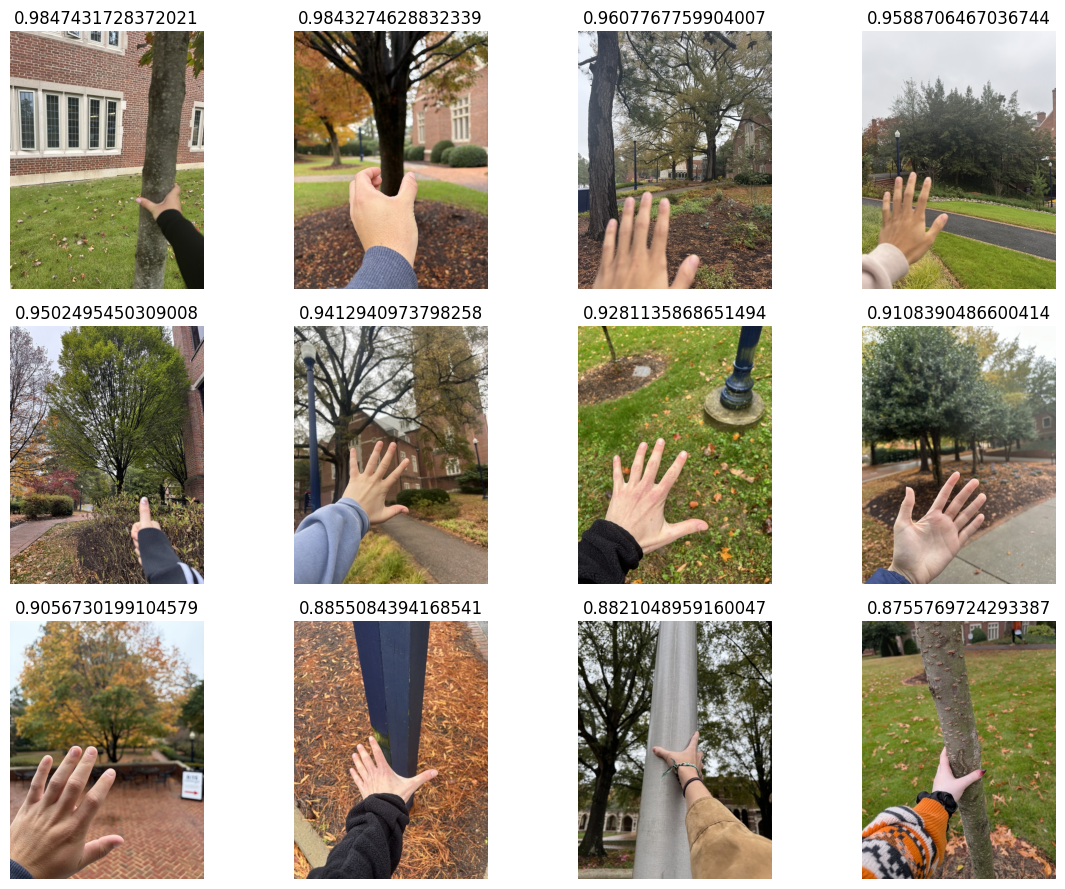

In [25]:
sim_score = []
txt_vec = siglip.embed_text("a hand grabbing a tree")
for idx, p in enumerate(df["path"]):
    sim_score.append(siglip.score(Z[idx, :], txt_vec))

df["sim_score"] = sim_score
temp = df.sort_values("sim_score", ascending=False)
show_images(temp["path"], temp["sim_score"])



As we did in the notes, let's use an embedding of the word "plant"
and then store all of the similarity scores in our dataset:



In [ ]:
sim_score = []
txt_vec = siglip.embed_text("plant")
for idx, p in enumerate(df["path"]):
    sim_score.append(siglip.score(Z[idx, :], txt_vec))

df["sim_score"] = sim_score



Plotting these relative to the labels, we see that the scores are clearly
related (but not perfectly so) to the labels:



In [ ]:
(
  ggplot(df, aes("sim_score", "label"))
  + geom_point()
)



Now, let's cycle through all of the labels to get the best prediction using
the zero-shot model.



In [ ]:
labels = list(set(df['label'].values))
label_emb = []
for idx, lab in enumerate(labels):
    label_emb.append(siglip.embed_text(lab))

label_emb = np.vstack(label_emb)

label_pred = []
for idx, p in enumerate(df["path"]):
    sim_score = []
    for idy, q in enumerate(labels):
        sim_score.append(
          siglip.score(Z[idx, :], label_emb[idy, :])
        )
    sim_score = np.array(sim_score)
    idz = np.argmax(sim_score)
    label_pred += [labels[idz]]

label_pred = np.array(label_pred)
y = df['label']



Using these predictions, we can compute the error rate:



In [ ]:
1 - accuracy_score(y, label_pred)



And a confusion matrix:



In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y,
    label_pred,
    xticks_rotation="vertical"
)



How does this perform compared to the embedding model? Any ideas how we
might make it better?

## 3. Bonus: Unsupervised Visualization

Let's do a quick example of some unsupervised learning to round out the week.
The sklearn module has great support for unsupervised learning and we can
load on the models that will be great for this dataset called `TSNE` using
the following:



In [ ]:
from sklearn.manifold import TSNE



The t-SNE model is part of a large class of algorithms that focus on a task
called *dimensionality reduction*. The goal is take a dataset that have a
of columns and create a small set of new features that represent certain
structures in the larger dataset. The embedding that we did above with the
ViT model is actually itself a form of dimensionality reduction, though it
was trained in a supervised way. We can use t-SNE to take the matrix Z and
generate a new representation of the data in just two dimensions. This new
version will lose much of the rich information in the original, but it works
by attempting to preserve which points are closest to which other points.
Here is how it works:



In [ ]:
model = TSNE(n_components=2, init="random", learning_rate="auto")
df_tsne = model.fit_transform(Z)
df["tsne1"] = df_tsne[:, 0]
df["tsne2"] = df_tsne[:, 1]



There are many applications of dimensionality reduction, but one particularly
imporant one that helps add some depth to our task above is visualization. Now
that we have the images represented as only two dimensions, we can easily plot
the relationships implied by the ViT model:



In [ ]:
(
  ggplot(df, aes("tsne1", "tsne2"))
  + geom_point(aes(color='label'))
)



For this reason, t-SNE and similar algorithms are frequently used as visualization
techniques when working with deep learning models.